# 9. Clustering

### 변수를 기준으로 clustering
### 변수 목록
- 버스 정류장과 마을회관의 거리
- 의료시설과 마을회관의 거리
- 상권과 마을회관의 거리
- 문화 서비스 센터(1.복지센터 2.도서관 3.영화관)와 마을회관의 거리
- 버스 배차 시간의 평균
- 노인인구 비율


In [254]:
import pandas as pd
from pandas import DataFrame
import numbers
import math
import numpy as np

In [255]:
distance=pd.read_csv("final_distance.csv", encoding='euc-kr') # 버스정류장, 의료시설, 상권, 문화센터와의 거리

senior_ratio=pd.read_csv("senior_population_dong.csv", encoding='euc-kr') # 노인 인구 비율
#senior_ratio=senior_ratio['aged_population_ratio']

bus_time=pd.read_csv("busStop_mean_time.csv", encoding='euc-kr') # 버스 배차 시간
bus_time=bus_time['busTime_mean']

In [256]:
# 데이터 길이 확인
print(len(distance))
print(len(senior_ratio))
print(len(bus_time))

622
23
622


In [257]:
df=pd.concat([distance, bus_time], axis=1, join='inner') # 거리 + 배차시간

In [258]:
df2=pd.merge(df, senior_ratio, on='dong', how='left') # '동'별로 같은 노인인구 비율 부여

In [260]:
# 변수 목록 이외 필요 없는 columns 제거
final_parameter=df2.drop(['Unnamed: 0_x', 'index', 'city', 'borough', 'address', 'X', 'Y', 'dong', 'Unnamed: 0_y', 'total_population', 'senior_population'], inplace=False, axis=1)

In [ ]:
final_parameter

In [262]:
final_parameter.to_csv("final_parameter.csv", encoding='euc-kr') # 최종 변수 파일 csv 저장

In [263]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [264]:
df=final_parameter.drop(['name'], inplace=False, axis=1) # 표준화를 위해 string 값인 ['name'] 삭제

### RobustScaler

In [ ]:
# RobustScaler 사용
robust_scaler = RobustScaler()
robust_scaler.fit(df)
df_robust_scaled=robust_scaler.transform(df)
np.mean(df_robust_scaled), np.std(df_robust_scaled)

In [266]:
df_robust_scaled=pd.DataFrame(df_robust_scaled)
df_robust_scaled.columns=df.columns # columns 추가

In [267]:
# 결측치 행 제거
df_robust_scaled=df_robust_scaled.dropna(axis=0)

In [268]:
df_robust_scaled.isnull().sum() # 결측치 확인
len(df_robust_scaled)

606

## K-means clustering

In [269]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt

In [270]:
# 최적의 k 값 찾기
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters =i,init ='k-means++',random_state=42)
    kmeans.fit(df_robust_scaled)
    wcss.append(kmeans.inertia_)

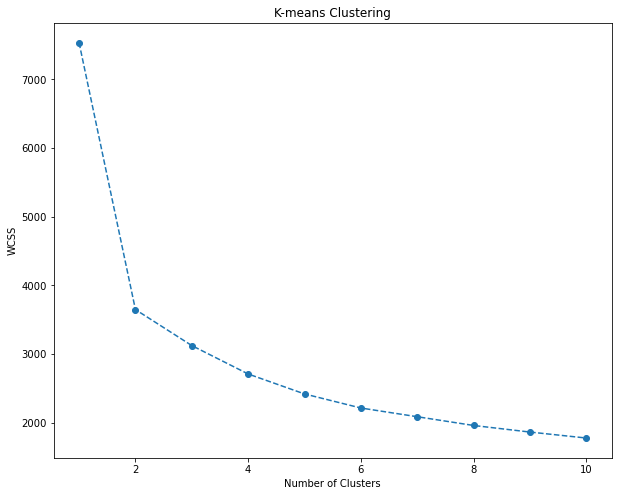

In [271]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering');

In [ ]:
# k = 5
kmeans = KMeans(n_clusters = 5, init = 'k-means++',random_state = 42)
kmeans.fit(df_robust_scaled)

y_predict=kmeans.fit_predict(df_robust_scaled) # k-means clustering 결과
#print(y_predict)

In [ ]:
y_predict=pd.DataFrame(y_predict)
y_predict.columns=['cluster_grade'] # column 이름 = 'clustering_grade'
#y_predict

In [274]:
# 결측치 제거
final_parameter=final_parameter.dropna(axis=0)
#final_parameter.isnull().sum()
len(final_parameter)

606

In [ ]:
# 기존 dataframe + clustering grade
# 최종 dataframe
cluster_5=pd.concat([final_parameter, y_predict], axis=1, join='inner')

In [276]:
# 군집화 마다 개수 확인
cluster_5['cluster_grade'].value_counts()

1    367
3    127
0     49
2     29
4     18
Name: cluster_grade, dtype: int64

In [300]:
cluster_5.to_csv("cluster_all.csv", encoding='euc-kr') # cluster 결과 csv 파일 저장

### 군집화 평균

In [277]:
grade_0=cluster_5.groupby(cluster_5['cluster_grade']==0).mean()
grade_1=cluster_5.groupby(cluster_5['cluster_grade']==1).mean()
grade_2=cluster_5.groupby(cluster_5['cluster_grade']==2).mean()
grade_3=cluster_5.groupby(cluster_5['cluster_grade']==3).mean()
grade_4=cluster_5.groupby(cluster_5['cluster_grade']==4).mean()

In [280]:
# 군집화 이름 설정 함수
def rename_col(grade_df, grade_name):
    grade_df=grade_df.T # 열 이름 변경을 위해 transpose
    grade_df=grade_df.drop([False], axis='columns')
    grade_df.rename(columns={True:grade_name}, inplace=True)
    
    grade_df=grade_df.T # 다시 transpose
    
    return grade_df

In [281]:
cluster_0=rename_col(grade_0, 'grade_0')
cluster_1=rename_col(grade_1, 'grade_1')
cluster_2=rename_col(grade_2, 'grade_2')
cluster_3=rename_col(grade_3, 'grade_3')
cluster_4=rename_col(grade_4, 'grade_4')

In [283]:
# 군집화 평균 dataframe
cluster=pd.concat([cluster_0, cluster_1, cluster_2, cluster_3, cluster_4], axis=0)

In [284]:
cluster

,busStop_distance,hospital_distance,store_distance,welfare_distance,library_distance,theater_distance,busTime_mean,aged_population_ratio,cluster_grade
cluster_grade,,,,,,,,,
grade_0,0.170317,1.069559,1.640162,3.151953,1.644202,2.953616,134.286923,0.167230,0.0
grade_1,0.168050,0.492118,0.681109,1.460326,0.696619,1.513694,98.857343,0.135619,1.0
grade_2,0.219149,1.748779,2.538689,2.979718,2.297090,3.774114,159.954316,0.189370,2.0
grade_3,0.153538,0.566128,1.073838,1.458181,0.820227,1.992866,110.627247,0.262204,3.0
grade_4,0.177885,0.567223,2.633722,4.184901,2.495456,4.375754,108.473722,0.172737,4.0


### 군집화 중 교통 취약지역을 최적 지역으로 선정

In [285]:
cluster_traffic=cluster.loc[:, ['busStop_distance', 'busTime_mean']]

In [286]:
cluster_traffic

,busStop_distance,busTime_mean
cluster_grade,,
grade_0,0.170317,134.286923
grade_1,0.168050,98.857343
grade_2,0.219149,159.954316
grade_3,0.153538,110.627247
grade_4,0.177885,108.473722


### grade_2가 교통 취약 지역임을 확인

In [ ]:
grade_2_df=cluster_5[cluster_5['cluster_grade']==2]
# grade_2_df

In [294]:
center_XY=distance.loc[:, ['name', 'X', 'Y']]
grade2_merge=pd.merge(grade_2_df, center_XY, on='name', how='left')
#grade2_merge=pd.merge(grade_2_df, distance, on='name', how='left')
#grade2_merge

In [297]:
grade2_merge.to_csv("grade2.csv", encoding='euc-kr')